In [13]:
import numpy as np
import pandas as pd
from IPython.display import display
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patheffects as path_effects

%matplotlib inline

datafile = 'abcnews-date-text.csv'
raw_data = pd.read_csv(datafile)

text_sample = raw_data['headline_text'][:1000]

display(text_sample.head())

0    aba decides against community broadcasting lic...
1       act fire witnesses must be aware of defamation
2       a g calls for infrastructure protection summit
3             air nz staff in aust strike for pay rise
4        air nz strike to affect australian travellers
Name: headline_text, dtype: object

In [14]:
text_sample.shape

(1000,)

In [15]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''returns a tuple of a list of the top n words in a sample and 
    a list of their accompanying counts, given a CountVectorizer object and text sample'''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.as_matrix())
    
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for word in 
             count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [16]:
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories 
    for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=20, 
                                     count_vectorizer=count_vectorizer, 
                                     text_data=text_sample)


In [18]:
from sklearn.decomposition import TruncatedSVD
n_topics = 4
document_term_matrix = count_vectorizer.fit_transform(text_sample)
lsa_model = TruncatedSVD(n_components=n_topics) # Instantiates the LSA model
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)
print(lsa_topic_matrix.shape)

(1000, 4)


In [25]:
lsa_topic_matrix[0]

array([0.00196424, 0.03120627, 0.00406338, 0.01793755])

In [19]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
# Define helper functions
def get_top_m_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains 
    the n most common words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
top_n_words_lsa = get_top_m_words(10, lsa_keys, 
                                  document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])


Topic 0:  man court face murder charged nightclub plane hospital leads jailed
Topic 1:  rain council nsw govt water drought says plan record claims
Topic 2:  iraq war new anti turkey pm world cup british resolution
Topic 3:  police death probe club korean help continue missing search killed


In [22]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=3, perplexity=50, 
                      learning_rate=100, n_iter=2000, verbose=1, 
                      random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.003727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.353737
[t-SNE] Error after 2000 iterations: 0.281649


NameError: name 'lsa_mean_topic_vectors' is not defined

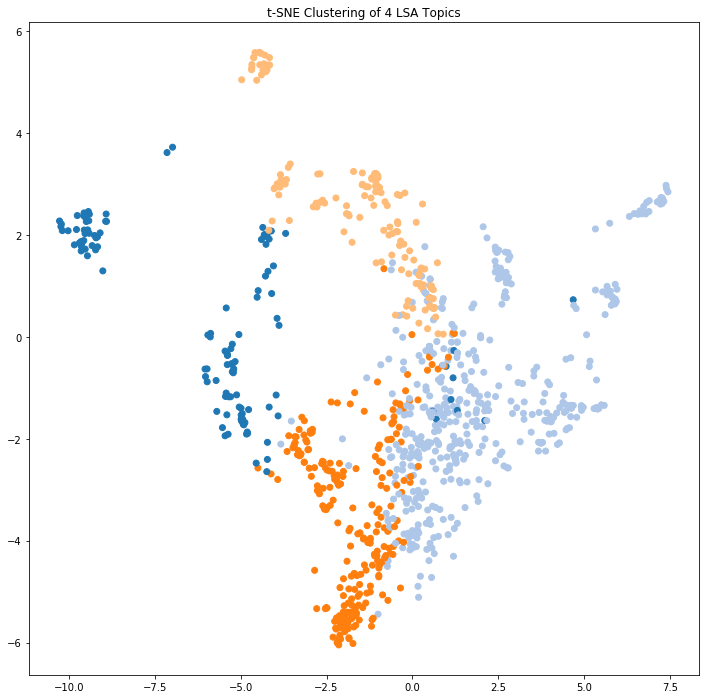

In [23]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''returns a list of centroid vectors from each predicted topic category'''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics] 

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], 
           color=colormap[lsa_keys])
ax.set_title("t-SNE Clustering of {} LSA Topics".format(n_topics));

for t in range(n_topics):
    ax.text(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
            s=top_3_words_lsa[t], color=colormap[t], 
            path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), 
                          path_effects.Normal()])